# Problem Set 5
## Ying Sun

## 1. Some income data, lognormal distribution, and GMM 

**(a)** Plot a histogram of percentages of the income data

In [1]:
import numpy as np
import scipy.stats as sts
import requests
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.optimize as opt
import numpy.linalg as lin

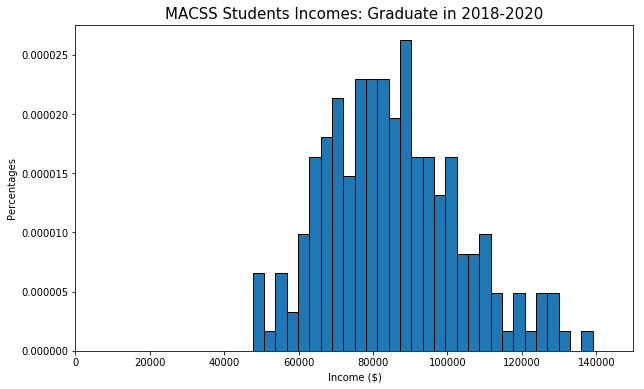

In [2]:
# Load the income data
incomes = np.loadtxt('incomes.txt')
# Plot the histogram
plt.figure(figsize=(10,6))
count, bins, ignored = plt.hist(incomes, 30, edgecolor='black', normed=True)
plt.title('MACSS Students Incomes: Graduate in 2018-2020', fontsize=15)
plt.xlabel('Income ($)')
plt.ylabel('Percentages')
plt.xlim([0, 150000])
plt.show()

**(b)** Estimate the parameters of the lognormal distribution by GMM

In [3]:
# Define function that generates values of a lognormal PDF
def lognorm_pdf(xvals, mu, sigma):
    '''
    --------------------------------------------------------------------
    Generate pdf values from the lognormal pdf with mean mu and
    standard deviation sigma. Note that in this function, the values
    of x must be nonnegative and also the sigma must be strictly postive
    --------------------------------------------------------------------
    INPUTS:
    xvals  = (N,) vector, values of the lognormally distributed random
             variable
    mu     = scalar, mean of the lognormally distributed random variable
    sigma  = scalar > 0, standard deviation of the lognormally distributed
             random variable
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION: None
    
    OBJECTS CREATED WITHIN FUNCTION:
    pdf_vals = (N,) vector, lognormal PDF values for mu and sigma
               corresponding to xvals data
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: pdf_vals
    --------------------------------------------------------------------
    '''          
    pdf_vals = (1/(xvals * sigma * np.sqrt(2 * np.pi)) * 
                np.exp( - (np.log(xvals) - mu)**2 / (2 * sigma**2)))
    
    return pdf_vals

In [4]:
def data_moments(xvals):
    '''
    --------------------------------------------------------------------
    This function computes the two data moments for GMM
    (mean(data), variance(data)).
    --------------------------------------------------------------------
    INPUTS:
    xvals = (N,) vector, test scores data
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION: None
    
    OBJECTS CREATED WITHIN FUNCTION:
    mean_data = scalar, mean value of test scores data
    var_data  = scalar > 0, variance of test scores data
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: mean_data, var_data
    --------------------------------------------------------------------
    '''
    mean_data = xvals.mean()
    std_data = xvals.std()
    
    return mean_data, std_data

In [5]:
def model_moments(mu, sigma):
    '''
    --------------------------------------------------------------------
    This function computes the two model moments for GMM
    (mean(model data), variance(model data)).
    --------------------------------------------------------------------
    INPUTS:
    mu     = scalar, mean of the lognormal distributed random variable
    sigma  = scalar > 0, standard deviation of the lognormal distributed
             random variable
    
    OBJECTS CREATED WITHIN FUNCTION:
    mean_model = scalar, mean value of test scores from model
    var_model  = scalar > 0, variance of test scores from model    
    std_model  = scalar > 0, standard deviation of test scores from model
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: mean_model, std_model
    --------------------------------------------------------------------
    '''
    
    mean_model = np.exp(mu + sigma ** 2/2)
    var_model = (np.exp(sigma ** 2) - 1) * np.exp(2 * mu + sigma**2)
    std_model = np.sqrt(var_model)
    
    return mean_model, std_model

In [6]:
def err_vec(xvals, mu, sigma, simple):
    '''
    --------------------------------------------------------------------
    This function computes the vector of moment errors (in percent
    deviation from the data moment vector) for GMM.
    --------------------------------------------------------------------
    INPUTS:
    xvals  = (N,) vector, test scores data
    mu     = scalar, mean of the normally distributed random variable
    sigma  = scalar > 0, standard deviation of the normally distributed
             random variable

    simple = boolean, =True if errors are simple difference, =False if
             errors are percent deviation from data moments
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION:
        data_moments()
        model_moments()
    
    OBJECTS CREATED WITHIN FUNCTION:
    mean_data  = scalar, mean value of data
    var_data   = scalar > 0, variance of data
    moms_data  = (2, 1) matrix, column vector of two data moments
    mean_model = scalar, mean value from model
    var_model  = scalar > 0, variance from model
    moms_model = (2, 1) matrix, column vector of two model moments
    err_vec    = (2, 1) matrix, column vector of two moment error
                 functions
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: err_vec
    --------------------------------------------------------------------
    '''
    mean_data, std_data = data_moments(xvals)
    moms_data = np.array([[mean_data], [std_data]])
    mean_model, std_model = model_moments(mu, sigma)
    moms_model = np.array([[mean_model], [std_model]])
    if simple:
        err_vec = moms_model - moms_data
    else:
        err_vec = (moms_model - moms_data) / moms_data
    
    return err_vec

In [7]:
def criterion(params, *args):
    '''
    --------------------------------------------------------------------
    This function computes the GMM weighted sum of squared moment errors
    criterion function value given parameter values and an estimate of
    the weighting matrix.
    --------------------------------------------------------------------
    INPUTS:
    params = (2,) vector, ([mu, sigma])
    mu     = scalar, mean of the normally distributed random variable
    sigma  = scalar > 0, standard deviation of the normally distributed
             random variable
    args   = length 2 tuple, (xvals, W_hat)
    xvals  = (N,) vector, values of the truncated normally distributed
             random variable
    W_hat  = (R, R) matrix, estimate of optimal weighting matrix
    

    
    OBJECTS CREATED WITHIN FUNCTION:
    err        = (2, 1) matrix, column vector of two moment error
                 functions
    crit_val   = scalar > 0, GMM criterion function value
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: crit_val
    --------------------------------------------------------------------
    '''
    mu, sigma = params
    xvals, W = args
    err = err_vec(xvals, mu, sigma, simple=False)
    crit_val = np.dot(np.dot(err.T, W), err) 
    
    return crit_val

Estimate the parameters by GMM:

In [8]:
# Set the initial mu and sigma
mu_init = 11 
sig_init = 0.5 
params_init = np.array([mu_init, sig_init])
W_hat = np.eye(2)
gmm_args = (incomes, W_hat)
results = opt.minimize(criterion, params_init, args=(gmm_args),
                       method='L-BFGS-B', bounds=((None, None), (1e-10, None)))
mu_GMM1, sig_GMM1 = results.x
print('mu_GMM1=', mu_GMM1, ' sig_GMM1=', sig_GMM1)

mu_GMM1= 11.3318807729154  sig_GMM1= 0.20869666648181137


Then we plot the estimated lognormal pdf against the histogram from part a.

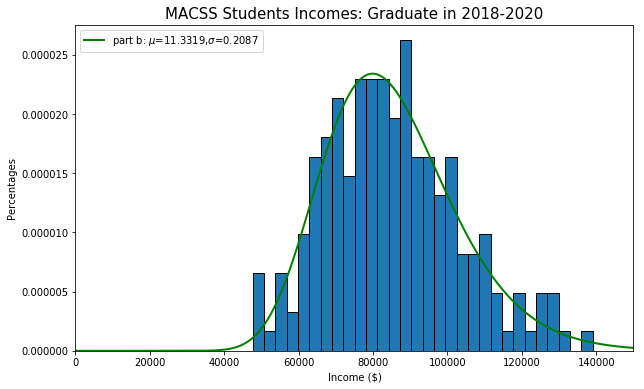

In [9]:
dist_income = np.linspace(0, 150000, 1000)
# Plot the histogram of the data
plt.figure(figsize=(10,6))
count, bins, ignored = plt.hist(incomes, 30, edgecolor='black', normed=True)
plt.title('MACSS Students Incomes: Graduate in 2018-2020', fontsize=15)
plt.xlabel('Income ($)')
plt.ylabel('Percentages')
plt.xlim([0,150000]) 

# Plot the GMM estimated distribution
plt.plot(dist_income, lognorm_pdf(dist_income, mu_GMM1, sig_GMM1),
         linewidth=2, color='g', label='part b: $\mu$={:.4f},$\sigma$={:.4f}'.\
         format(mu_GMM1, sig_GMM1))
plt.legend(loc='upper left')

In [10]:
print('The value of GMM criterion function:', float(results.fun))
mean_data, std_data = data_moments(incomes)
mean_model, std_model = model_moments(mu_GMM1, sig_GMM1)
err1 = err_vec(incomes, mu_GMM1, sig_GMM1, False).reshape(2,)
print()
print('The two data moments are:')
print('The mean of data =', mean_data, ', The standard deviation of data =', std_data)
print()
print('The two model moments are:')
print('The mean of model =', mean_model, ', The standard deviation of model =', std_model)
print()
print('The differences in data and model moments are: diff_mu = {}, diff_sigma = {}'.format(
    mean_data - mean_model, std_data- std_model))
print()
print('The error vector=', err1)

The value of GMM criterion function: 6.995503784495091e-15

The two data moments are:
The mean of data = 85276.82360625811 , The standard deviation of data = 17992.542128046523

The two model moments are:
The mean of model = 85276.81764993032 , The standard deviation of model = 17992.541300212713

The differences in data and model moments are: diff_mu = 0.005956327790045179, diff_sigma = 0.0008278338100353722

The error vector= [-6.98469706e-08 -4.60098303e-08]


**(c)** Perform the two-step GMM estimator

First, we calculate the variance covariance matrix.

In [11]:
err2 = err_vec(incomes, mu_GMM1, sig_GMM1, False)
VCV2 = np.dot(err2, err2.T) / incomes.shape[0]
print('The variance covariance matrix is:')
print(VCV2)

The variance covariance matrix is:
[[2.43929965e-17 1.60682363e-17]
 [1.60682363e-17 1.05845224e-17]]


Then we calculate the optimal weighting matrix:

In [12]:
W_hat2 = lin.pinv(VCV2) 
print('The optimal weighting matrix is:')
print(W_hat2)

The optimal weighting matrix is:
[[1.99382553e+16 1.31337943e+16]
 [1.31337943e+16 8.65153695e+15]]


Next we do the two-step GMM estimation:

In [13]:
params_init = np.array([mu_GMM1, sig_GMM1])
gmm_args = (incomes, W_hat2)
results2 = opt.minimize(criterion, params_init, args=(gmm_args),
                       method='L-BFGS-B', bounds=((None, None), (1e-10, None)))
mu_GMM2, sig_GMM2 = results2.x
print('mu_GMM2=', mu_GMM2, ' sig_GMM2=', sig_GMM2)

mu_GMM2= 11.331880811066142  sig_GMM2= 0.20869667679522338


Now we plot this estimation against the histogram from part(a) and the estimation from part(b):

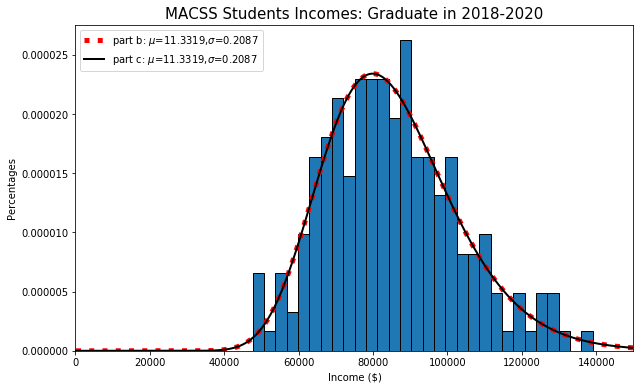

In [14]:
# plot the histogram
plt.figure(figsize=(10,6))
count, bins, ignored = plt.hist(incomes, 30, edgecolor='black', normed=True)
plt.title('MACSS Students Incomes: Graduate in 2018-2020', fontsize=15)
plt.xlabel('Income ($)')
plt.ylabel('Percentages')
plt.xlim([0,150000]) 

# plot the estimation of part b
plt.plot(dist_income, lognorm_pdf(dist_income, mu_GMM1, sig_GMM1),
         linewidth=5, color='r', label='part b: $\mu$={:.4f},$\sigma$={:.4f}'.\
         format(mu_GMM1, sig_GMM1), linestyle= ':')
plt.legend(loc='upper left')

# plot the estimation of part c
plt.plot(dist_income, lognorm_pdf(dist_income, mu_GMM2, sig_GMM2),
         linewidth=2, color='k', label='part c: $\mu$={:.4f},$\sigma$={:.4f}'.\
         format(mu_GMM2, sig_GMM2))
plt.legend(loc='upper left')

In [15]:
print('The value of GMM criterion function:', float(results2.fun))
mean_data, std_data = data_moments(incomes)
mean_model_2, std_model_2 = model_moments(mu_GMM2, sig_GMM2)
err3 = err_vec(incomes, mu_GMM2, sig_GMM2, False).reshape(2,)
print()
print('The two data moments are:')
print('The mean of data =', mean_data, ', The standard deviation of data =', std_data)
print()
print('The two model moments are:')
print('The mean of model =', mean_model_2, ', The standard deviation of model =', std_model_2)
print()
print('The difference in data and model moments are: diff_mu = {}, diff_sigma = {}'.format(
    mean_data - mean_model_2, std_data - std_model_2))
print()
print('The error vector=', err3)

The value of GMM criterion function: 2.5881047412606994e-05

The two data moments are:
The mean of data = 85276.82360625811 , The standard deviation of data = 17992.542128046523

The two model moments are:
The mean of model = 85276.82108685197 , The standard deviation of model = 17992.542934031037

The difference in data and model moments are: diff_mu = 0.002519406145438552, diff_sigma = -0.0008059845131356269

The error vector= [-2.95438554e-08  4.47954773e-08]


**(d)** Estimate the lognormal PDF to fit the data by GMM using different moments.

In [16]:
def data_moments3(xvals):
    '''
    --------------------------------------------------------------------
    This function computes the three data moments for GMM
    (binpct_1, binpct_2, binpct_3).
    --------------------------------------------------------------------
    INPUTS:
    xvals = (N,) vector, test scores data

    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION: None

    OBJECTS CREATED WITHIN FUNCTION:
    bpct_1_dat = scalar in [0, 1], percent of observations
                 0 <= x < 75000
    bpct_2_dat = scalar in [0, 1], percent of observations
                 75000 <= x < 100000
    bpct_3_dat = scalar in [0, 1], percent of observations
                 100000 <= x 


    FILES CREATED BY THIS FUNCTION: None

    RETURNS: bpct_1, bpct_2, bpct_3
    --------------------------------------------------------------------
    '''
    bpct_1_dat = xvals[xvals < 75000].shape[0] / xvals.shape[0]
    bpct_2_dat = (xvals[(xvals >=75000) & (xvals < 100000)].shape[0] / xvals.shape[0])
    bpct_3_dat = xvals[xvals >=100000].shape[0] / xvals.shape[0]

    return bpct_1_dat, bpct_2_dat, bpct_3_dat


def model_moments3(mu, sigma):
    '''
    --------------------------------------------------------------------
    This function computes the three model moments for GMM
    (binpct_1, binpct_2, binpct_3).
    --------------------------------------------------------------------
    INPUTS:
    mu     = scalar, mean of the normally distributed random variable
    sigma  = scalar > 0, standard deviation of the normally distributed
             random variable

    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION:
        sts.norm.cdf

    
    OBJECTS CREATED WITHIN FUNCTION:
    bpct_1_mod = scalar in [0, 1], percent of model observations in
                 bin 1
    bpct_2_mod = scalar in [0, 1], percent of model observations in
                 bin 2
    bpct_3_mod = scalar in [0, 1], percent of model observations in
                 bin 3

    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: bpct_1_mod, bpct_2_mod, bpct_3_mod
    --------------------------------------------------------------------
    '''

    bpct_1_mod = sts.norm.cdf(np.log(75000), loc = mu, scale = sigma)
    bpct_2_mod = sts.norm.cdf(np.log(100000), loc = mu, scale = sigma) - bpct_1_mod
    bpct_3_mod = 1 - sts.norm.cdf(np.log(100000), loc = mu, scale = sigma)
    
    return bpct_1_mod, bpct_2_mod, bpct_3_mod


def err_vec3(xvals, mu, sigma, simple):
    '''
    --------------------------------------------------------------------
    This function computes the vector of moment errors (in percent
    deviation from the data moment vector) for GMM.
    --------------------------------------------------------------------
    INPUTS:
    xvals  = (N,) vector, test scores data
    mu     = scalar, mean of the normally distributed random variable
    sigma  = scalar > 0, standard deviation of the normally distributed
             random variable
    simple = boolean, =True if errors are simple difference, =False if
             errors are percent deviation from data moments
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION:
        data_moments3()
        model_moments3()
    
    OBJECTS CREATED WITHIN FUNCTION:
    mean_data  = scalar, mean value of data
    var_data   = scalar > 0, variance of data
    moms_data  = (2, 1) matrix, column vector of two data moments
    mean_model = scalar, mean value from model
    var_model  = scalar > 0, variance from model
    moms_model = (2, 1) matrix, column vector of two model moments
    err_vec    = (2, 1) matrix, column vector of two moment error
                 functions
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: err_vec
    --------------------------------------------------------------------
    '''
    bpct_1_dat, bpct_2_dat, bpct_3_dat = data_moments3(xvals)
    moms_data = np.array([[bpct_1_dat], [bpct_2_dat], [bpct_3_dat]])
    bpct_1_mod, bpct_2_mod, bpct_3_mod = model_moments3(mu, sigma)
    moms_model = np.array([[bpct_1_mod], [bpct_2_mod], [bpct_3_mod]])
    if simple:
        err_vec = moms_model - moms_data
    else:
        err_vec = 100 * ((moms_model - moms_data) / moms_data)
    
    return err_vec

def criterion3(params, *args):
    '''
    --------------------------------------------------------------------
    This function computes the GMM weighted sum of squared moment errors
    criterion function value given parameter values and an estimate of
    the weighting matrix.
    --------------------------------------------------------------------
    INPUTS:
    params = (2,) vector, ([mu, sigma])
    mu     = scalar, mean of the normally distributed random variable
    sigma  = scalar > 0, standard deviation of the normally distributed
             random variable
    args   = length 2 tuple, (xvals, W_hat)
    xvals  = (N,) vector, values of the truncated normally distributed
             random variable
    W_hat  = (R, R) matrix, estimate of optimal weighting matrix
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION:
        err_vec3()
    
    OBJECTS CREATED WITHIN FUNCTION:
    err        = (3, 1) matrix, column vector of three moment error
                 functions
    crit_val   = scalar > 0, GMM criterion function value
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: crit_val
    --------------------------------------------------------------------
    '''
    mu, sigma = params
    xvals, W = args
    err = err_vec3(xvals, mu, sigma, simple=False)
    crit_val = np.dot(np.dot(err.T, W), err) 
    
    return crit_val

GMM estimation of three moments:

In [17]:
mu_init = 11
sig_init = 0.5
params_init = np.array([mu_init, sig_init])
W_hat = np.eye(3)
gmm_args = (incomes, W_hat)
results_3 = opt.minimize(criterion3, params_init, args=(gmm_args),
                       method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None)))
mu_GMM1_3, sig_GMM1_3 = results_3.x
print('mu_GMM1_3=', mu_GMM1_3, ' sig_GMM1_3=', sig_GMM1_3)

mu_GMM1_3= 11.335681327424783  sig_GMM1_3= 0.2105984537206961


Then we plot the estimated result against the histogram of part (a)

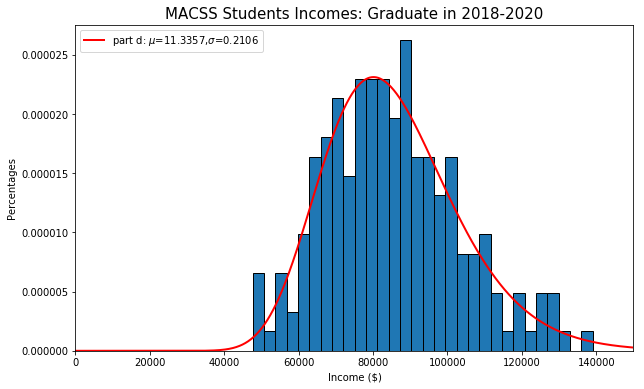

In [18]:
# plot the histogram
plt.figure(figsize=(10,6))
count, bins, ignored = plt.hist(incomes, 30, edgecolor='black', normed=True)
plt.title('MACSS Students Incomes: Graduate in 2018-2020', fontsize=15)
plt.xlabel('Income ($)')
plt.ylabel('Percentages')
plt.xlim([0,150000]) 

# plot the GMM estimated result above
dist_income = np.linspace(0, 150000, 1000)
plt.plot(dist_income, lognorm_pdf(dist_income, mu_GMM1_3, sig_GMM1_3),
         linewidth=2, color='r', label='part d: $\mu$={:.4f},$\sigma$={:.4f}'.\
         format(mu_GMM1_3, sig_GMM1_3))
plt.legend(loc='upper left')

In [19]:
print('The value of GMM criterion function:', float(results_3.fun))
bpct_1_dat, bpct_2_dat, bpct_3_dat = data_moments3(incomes)
bpct_1_mod, bpct_2_mod, bpct_3_mod = model_moments3(mu_GMM1_3, sig_GMM1_3)
err_4 = err_vec3(incomes, mu_GMM1_3, sig_GMM1_3, False).reshape(3,)
print()
print('The three data moments are:', (bpct_1_dat, bpct_2_dat, bpct_3_dat))
print()
print('The three model moments are:', (bpct_1_mod, bpct_2_mod, bpct_3_mod))
print()
print('The error vector=', err_4)

The value of GMM criterion function: 2.533788396727552e-11

The three data moments are: (0.3, 0.5, 0.2)

The three model moments are: (0.3000000036326669, 0.500000005854316, 0.1999999905130171)

The error vector= [ 1.21088896e-06  1.17086321e-06 -4.74349146e-06]


**(e)** Perform the two-step GMM estimator by using your estimates from part (d)

First we calculate the variance and covariance matrix and the optimal weighting matrix:

In [20]:
err1_3= err_vec3(incomes, mu_GMM1_3, sig_GMM1_3, False)
VCV2_3 = np.dot(err1_3, err1_3.T) / incomes.shape[0]
print('The variance covariance matrix is:')
print(VCV2_3)
print()
W_hat2_3 = lin.pinv(VCV2_3) 
print('The optimal weighting matrix is:')
print(W_hat2_3)

The variance covariance matrix is:
[[ 7.33126041e-15  7.08892667e-15 -2.87192073e-14]
 [ 7.08892667e-15  6.85460324e-15 -2.77698981e-14]
 [-2.87192073e-14 -2.77698981e-14  1.12503556e-13]]

The optimal weighting matrix is:
[[ 4.56770398e+11  4.41671920e+11 -1.78933540e+12]
 [ 4.41671920e+11  4.27072520e+11 -1.73018918e+12]
 [-1.78933540e+12 -1.73018918e+12  7.00947604e+12]]


Then we do two-step GMM estimation:

In [21]:
params_init = np.array([mu_GMM1_3, sig_GMM1_3])
gmm_args = (incomes, W_hat2_3)
results2_3 = opt.minimize(criterion3, params_init, args=(gmm_args),
                       method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None)))
mu_GMM2_3, sig_GMM2_3 = results2_3.x
print('mu_GMM2_3=', mu_GMM2_3, ' sig_GMM2_3=', sig_GMM2_3)

mu_GMM2_3= 11.335681328652415  sig_GMM2_3= 0.21059845621179624


Next we plot this estimated results against with part (a) and part(d):

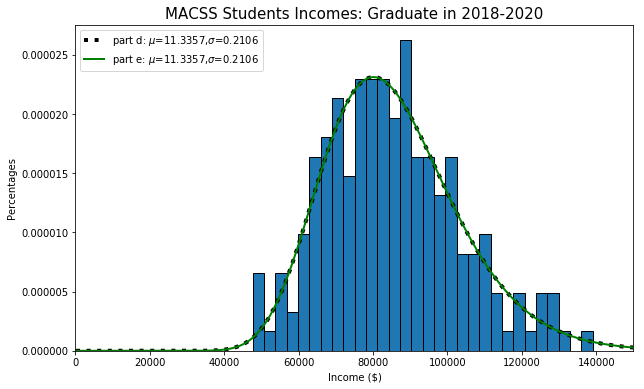

In [22]:
# plot the histogram
plt.figure(figsize=(10,6))
count, bins, ignored = plt.hist(incomes, 30, edgecolor='black', normed=True)
plt.title('MACSS Students Incomes: Graduate in 2018-2020', fontsize=15)
plt.xlabel('Income ($)')
plt.ylabel('Percentages')
plt.xlim([0,150000]) 

# plot the GMM estimated result of part d
dist_income = np.linspace(0, 150000, 1000)
plt.plot(dist_income, lognorm_pdf(dist_income, mu_GMM1_3, sig_GMM1_3),
         linewidth=4, color='k', label='part d: $\mu$={:.4f},$\sigma$={:.4f}'.\
         format(mu_GMM1_3, sig_GMM1_3), linestyle= ':')
plt.legend(loc='upper left')

# plot the GMM estimated result of part e
plt.plot(dist_income, lognorm_pdf(dist_income, mu_GMM2_3, sig_GMM2_3),
         linewidth=2, color='g', label='part e: $\mu$={:.4f},$\sigma$={:.4f}'.\
         format(mu_GMM2_3, sig_GMM2_3))
plt.legend(loc='upper left')

In [23]:
print('The value of GMM criterion function:', float(results2_3.fun))
bpct_1_dat2, bpct_2_dat2, bpct_3_dat2 = data_moments3(incomes)
bpct_1_mod2, bpct_2_mod2, bpct_3_mod2 = model_moments3(mu_GMM2_3, sig_GMM2_3)
err_3_2 = err_vec3(incomes, mu_GMM2_3, sig_GMM2_3, False).reshape(3,)
print()
print('Three data moments are:', (bpct_1_dat2, bpct_2_dat2, bpct_3_dat2))
print()
print('Three model moments are:', (bpct_1_mod2, bpct_2_mod2, bpct_3_mod2))
print()
print('Error vector=', err_3_2)

The value of GMM criterion function: 59.70685018035181

Three data moments are: (0.3, 0.5, 0.2)

Three model moments are: (0.3000000037626033, 0.500000001305317, 0.19999999493207976)

Error vector= [ 1.25420109e-06  2.61063393e-07 -2.53396013e-06]


**(f)** Which of the four estimates from part (b), (c), (d) and (e) fits the data best?

In [24]:
print('GMM 1: ', results.x)
print('GMM 2: ', results2.x)
print('GMM 3: ', results_3.x)
print('GMM 4: ', results2_3.x)

GMM 1:  [11.33188077  0.20869667]
GMM 2:  [11.33188081  0.20869668]
GMM 3:  [11.33568133  0.21059845]
GMM 4:  [11.33568133  0.21059846]


Based on the above results, we can find they are nearly identical and there are only trivial differences among them. From my personal perspective, the model in part (c) fits the data best. Because the three model moments used in (d) and (e) will increase the error so decreases the accuracy. Comparing the models in part (c) and part (b), two step estimation should be more accurate than the identity matrix used in (b).

## 2. Linear regression and GMM

In [25]:
import pandas as pd
sick = pd.read_csv('sick.txt')
sick.head()

,sick,age,children,avgtemp_winter
0,1.67,57.47,3.04,54.10
1,0.71,26.77,1.20,36.54
2,1.39,41.85,2.31,32.38
3,1.37,51.27,2.46,52.94
4,1.45,44.22,2.72,45.90


In [26]:
def data_moments4(x):
    return x['sick']

def model_moments4(x, b):
    b0, b1, b2, b3 = b
    return b0 + b1 * x['age'] + b2 * x['children'] + b3 * x['avgtemp_winter']

def err_vec4(x, b):
    return data_moments4(x) - model_moments4(x,b)

def criterion4(params, *args):
    b = params
    x, W = args
    err = err_vec4(x,b)
    crit_val =err.dot(err.T.dot(W)) 
    
    return crit_val

In [27]:
params_init_4 = np.array([1,0,0,0])
W_4 = np.eye(sick.shape[0])
gmm_args_4 = (sick, W_4)
results_sick = opt.minimize(criterion4, params_init_4, args=(gmm_args_4),
                       method='L-BFGS-B')
b0,b1,b2,b3 = results_sick.x
print('beta 0: ', b0)
print('beta 1: ', b1)
print('beta 2: ', b2)
print('beta 3: ', b3)
print('The value of criterion function: ', results_sick.fun)

beta 0:  0.2516448640151442
beta 1:  0.012933471011881827
beta 2:  0.4005009841273648
beta 3:  -0.009991709739766598
The value of criterion function:  0.0018212898060392675
